# Conclusion
Our method is robust to the choice of $\beta$.
But the ideal choice of $\beta\in\{0.1,0.01\}$

## 

In [1]:
import pandas as pd
import os
import json
import numpy as np


def collect_data_p(p: str, datasets=[], result_dir='results', train_test_flag="test"):
    """
    Collects data from multiple datasets and methods for a specific missingness percentage,
    and formats it into a DataFrame.
    
    Args:
        p (str): The missingness percentage (e.g., "0.0").
        datasets (list): List of dataset names to analyze.
        output_dir (str): The base directory where results are saved.
        
    Returns:
        pd.DataFrame: A DataFrame containing formatted results for each method and imputation.
    """
    if not datasets:
        datasets = [d for d in os.listdir(result_dir) if os.path.isdir(os.path.join(result_dir, d))]
    
    for dataset in datasets[1:]:
        dataset_dir = os.path.join(result_dir, dataset)
        method_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
        break
    # print(method_dirs)
    method_dirs = [e for e in method_dirs if 'Balu' in e] # or 'gnn' in e or '9' in e or '10' in e]
    print("methods:", method_dirs)

    def fileter_method(must_item: list, method):
        method_name = method
        for item in must_item:
            if item not in method:
                return False, None
            if "L=" in item or 'Balu_plus' in item:
                item = item 
            else:
                item = "_"+item
            method_name = method_name.replace(item, "")
        return True, method_name

    def safe_float_convert(value):
        if value is None:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    # 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001'

    data_rows = []
    raw_data_rows = []
    for method in method_dirs:
        flag, method_name = fileter_method(['Balu_plus_imp=', 'L=64-64_K=64', "gconv=GCN_rconv=GCN", "reldrop=0.0", "gamma=0.0001_eta=0.0001"], method)
        if not flag:
            continue
        if "-64" in method_name or "BaLu" not in method_name:
            continue
        
        row = {
            'method': method_name,
            # 'imputation': imputation
        }
        
        # Collect results for each dataset
        for dataset in datasets:
            dataset_dir = os.path.join(result_dir, dataset)
            if not os.path.exists(dataset_dir):
                print(f"{dataset_dir} not exits!")
                # Dataset doesn't exist, fill with N/A
                row[f"{dataset}_PEHE"] = "N/A"
                row[f"{dataset}_MAE"] = "N/A"
                continue
                
            method_dir = os.path.join(dataset_dir, method)
            if not os.path.exists(method_dir):
                # Method doesn't exist for this dataset, fill with N/A
                row[f"{dataset}_PEHE"] = "N/A"
                row[f"{dataset}_MAE"] = "N/A"
                continue
            
            imputation_dir = method_dir
            
            results_files = [f for f in os.listdir(imputation_dir) 
                        if f.startswith(f"p={p}_") and f.endswith(f"_{train_test_flag}_results.json")]
            if "complete" not in train_test_flag:
                results_files = [f for f in results_files if "complete" not in f]
            # results_files=results_files[:len(results_files)*1.5//2]

            # print(results_files)
            effect_pehe_values = []
            effect_mae_values = []
            effect_sum_values = []
            
            # print(results_files)
            for file in results_files:
                file_path = os.path.join(method_dir, file) # imputation, file)
                try:
                    with open(file_path, 'r') as f:
                        results = json.load(f)
                        pehe_val = safe_float_convert(results.get('effect_pehe'))
                        mae_val = safe_float_convert(results.get('effect_mae'))
                        
                        # Check for problematic values
                        if np.isnan(pehe_val) or np.isnan(mae_val):
                            print(f"NaN detected in: {file_path}")
                            print(f"  PEHE: {results.get('effect_pehe')} -> {pehe_val}")
                            print(f"  MAE: {results.get('effect_mae')} -> {mae_val}")
                            continue  # Skip this file entirely
                        
                        # Only add valid values
                        effect_pehe_values.append(pehe_val)
                        effect_mae_values.append(mae_val)
                        sum_val = pehe_val + mae_val
                        effect_sum_values.append(sum_val)
                        
                        raw_data_rows.append({
                            'method': method_name,
                            'Dataset': dataset,
                            f'PEHE': pehe_val,
                            f"MAE": mae_val,
                            f"SUM": sum_val
                        })

                except (json.JSONDecodeError, FileNotFoundError) as e:
                    print(f"Warning: Error reading file {file_path}: {e}")
            
            if effect_pehe_values:
                mean_pehe = np.mean(effect_pehe_values)
                std_pehe = np.std(effect_pehe_values)
                row[f"{dataset}_PEHE"] = f"{mean_pehe:.2f} ± {std_pehe:.2f}"
            else:
                row[f"{dataset}_PEHE"] = "N/A"
            
            if effect_mae_values:
                mean_mae = np.mean(effect_mae_values)
                std_mae = np.std(effect_mae_values)
                row[f"{dataset}_MAE"] = f"{mean_mae:.2f} ± {std_mae:.2f}"
            else:
                row[f"{dataset}_MAE"] = "N/A"

            if effect_sum_values:
                mean_sum = np.mean(effect_sum_values)
                std_sum = np.std(effect_sum_values)
                row[f"{dataset}_SUM"] = f"{mean_sum:.2f} ± {std_sum:.2f}"
            else:
                row[f"{dataset}_SUM"] = 'N/A'
        data_rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    df_raw = pd.DataFrame(raw_data_rows)
    
    
    # Sort the DataFrame by method and imputation
    if not df.empty:
        df = df.sort_values(by=['method']) #, 'imputation'])
        df_raw = df_raw.sort_values(by=['method'])
    return df, df_raw

def display_results(result_dir, p, datasets=["Syn"], train_test_flag='test', metrics=['SUM']):
    

    # Set display options to show all rows and columns
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', None)  # Use the full width of the notebook cell
    pd.set_option('display.max_colwidth', None)  # Show full content of each column

    # Example: Display the DataFrame created by collect_data_p
    df, _ = collect_data_p(p, datasets=datasets, result_dir=result_dir, train_test_flag=train_test_flag) 
    dataset_map = {'Syn_M=None_SimRel=1_Rel=4':"Instagram",  'BlogCatalog1_M=20_SimRel=0_Rel=1':"BlogCatalog", 'BlogCatalog1_M=20_SimRel=1_Rel=4':"BlogCatalog", 'Flickr1_M=20_SimRel=0_Rel=1':"Flickr", 'Flickr1_M=20_SimRel=1_Rel=4':"Flickr", 'Youtube_M=20_SimRel=1_Rel=4':"Youtube"}
    
    def replace_col(col):
        for k, v in dataset_map.items():
            if k in col:

                return col.replace(k, v).replace("_MCAR","")
        return col

    new_column_names = [replace_col(col) for col in df.columns]
    df.columns = new_column_names
    display(df)
    # print(df.to_latex(index=False, escape=False))
    # print(df.to_markdown(index=False))

# display_results(p='0.5', train_test_flag='test')

In [2]:
datasets = ['Syn_M=None_SimRel=1_Rel=4', 'Youtube_M=20_SimRel=1_Rel=4', 'BlogCatalog1_M=20_SimRel=0_Rel=1', 'Flickr1_M=20_SimRel=0_Rel=1']     # , 'BlogCatalog1_M=20_SimRel=1_Rel=4', 'Flickr1_M=20_SimRel=1_Rel=4'
datasets = [e+"_MCAR" for e in datasets] 
result_dir = 'results_balu_tuning'

display_results(result_dir=result_dir, p='0.0', datasets=datasets, train_test_flag='test')
display_results(result_dir=result_dir, p='0.1', datasets=datasets, train_test_flag='test')
display_results(result_dir=result_dir, p='0.3', datasets=datasets, train_test_flag='test')
# display_results(result_dir='results_Q1', p='0.5', datasets=datasets, train_test_flag='test')


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

,method,Instagram_PEHE,Instagram_MAE,Instagram_SUM,Youtube_PEHE,Youtube_MAE,Youtube_SUM,BlogCatalog_PEHE,BlogCatalog_MAE,BlogCatalog_SUM,Flickr_PEHE,Flickr_MAE,Flickr_SUM
5,BaLu_GRAPE_beta=0.0,0.80 ± 0.03,0.05 ± 0.04,0.85 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.03,7.33 ± 3.74,0.98 ± 0.54,8.31 ± 4.09,7.14 ± 1.85,1.01 ± 0.46,8.16 ± 2.08
8,BaLu_GRAPE_beta=0.0001,0.80 ± 0.03,0.05 ± 0.04,0.86 ± 0.04,0.79 ± 0.02,0.03 ± 0.03,0.83 ± 0.04,7.30 ± 3.72,0.93 ± 0.47,8.23 ± 4.06,7.25 ± 1.73,1.03 ± 0.46,8.29 ± 1.93
3,BaLu_GRAPE_beta=0.001,0.80 ± 0.03,0.05 ± 0.04,0.85 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.03,7.25 ± 3.70,0.93 ± 0.48,8.18 ± 4.00,7.15 ± 1.73,1.03 ± 0.48,8.18 ± 1.93
2,BaLu_GRAPE_beta=0.01,0.80 ± 0.03,0.05 ± 0.03,0.85 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.03,7.15 ± 3.74,0.80 ± 0.40,7.95 ± 4.07,7.02 ± 1.82,1.02 ± 0.45,8.03 ± 2.02
1,BaLu_GRAPE_beta=0.1,0.78 ± 0.01,0.05 ± 0.04,0.83 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.03,7.27 ± 3.97,0.74 ± 0.52,8.00 ± 4.40,7.19 ± 1.65,0.99 ± 0.46,8.18 ± 1.88
0,BaLu_IGMC_beta=0.0,0.81 ± 0.03,0.06 ± 0.03,0.87 ± 0.04,0.79 ± 0.02,0.02 ± 0.02,0.81 ± 0.04,7.45 ± 3.97,0.85 ± 0.64,8.30 ± 4.34,7.42 ± 1.70,1.10 ± 0.39,8.52 ± 1.70
7,BaLu_IGMC_beta=0.0001,0.80 ± 0.02,0.06 ± 0.03,0.86 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.04,7.45 ± 3.96,0.90 ± 0.61,8.35 ± 4.31,7.44 ± 1.76,1.09 ± 0.38,8.53 ± 1.77
4,BaLu_IGMC_beta=0.001,0.80 ± 0.02,0.06 ± 0.03,0.86 ± 0.04,0.79 ± 0.02,0.02 ± 0.02,0.81 ± 0.04,7.41 ± 3.88,0.93 ± 0.83,8.35 ± 4.50,7.40 ± 1.67,1.08 ± 0.39,8.49 ± 1.69
9,BaLu_IGMC_beta=0.01,0.80 ± 0.02,0.06 ± 0.03,0.86 ± 0.04,0.79 ± 0.02,0.02 ± 0.02,0.82 ± 0.03,7.46 ± 3.96,0.84 ± 0.68,8.30 ± 4.37,7.51 ± 1.74,1.10 ± 0.38,8.61 ± 1.93
6,BaLu_IGMC_beta=0.1,0.79 ± 0.02,0.05 ± 0.04,0.84 ± 0.04,0.79 ± 0.02,0.02 ± 0.01,0.81 ± 0.01,7.53 ± 4.04,0.92 ± 0.94,8.45 ± 4.77,7.49 ± 1.85,1.06 ± 0.41,8.55 ± 1.78


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

,method,Instagram_PEHE,Instagram_MAE,Instagram_SUM,Youtube_PEHE,Youtube_MAE,Youtube_SUM,BlogCatalog_PEHE,BlogCatalog_MAE,BlogCatalog_SUM,Flickr_PEHE,Flickr_MAE,Flickr_SUM
5,BaLu_GRAPE_beta=0.0,2.09 ± 0.30,0.47 ± 0.29,2.56 ± 0.52,1.99 ± 0.23,0.14 ± 0.10,2.13 ± 0.28,8.52 ± 6.74,1.17 ± 0.58,9.69 ± 7.01,8.44 ± 2.79,0.64 ± 0.58,9.08 ± 3.10
8,BaLu_GRAPE_beta=0.0001,1.88 ± 0.23,0.31 ± 0.19,2.19 ± 0.29,1.91 ± 0.20,0.12 ± 0.06,2.03 ± 0.20,7.64 ± 4.26,0.92 ± 0.52,8.56 ± 4.54,7.94 ± 2.85,0.59 ± 0.38,8.53 ± 3.12
3,BaLu_GRAPE_beta=0.001,1.88 ± 0.23,0.31 ± 0.19,2.19 ± 0.28,1.91 ± 0.20,0.10 ± 0.07,2.01 ± 0.23,7.72 ± 4.89,0.75 ± 0.47,8.47 ± 5.15,7.99 ± 2.79,0.90 ± 0.59,8.89 ± 3.08
2,BaLu_GRAPE_beta=0.01,1.88 ± 0.23,0.32 ± 0.21,2.20 ± 0.31,1.91 ± 0.20,0.11 ± 0.07,2.02 ± 0.22,7.80 ± 4.70,0.81 ± 0.71,8.61 ± 5.12,8.04 ± 2.89,0.70 ± 0.28,8.73 ± 3.00
1,BaLu_GRAPE_beta=0.1,1.81 ± 0.17,0.31 ± 0.13,2.12 ± 0.21,1.90 ± 0.19,0.12 ± 0.07,2.02 ± 0.22,7.80 ± 4.62,0.78 ± 0.66,8.58 ± 4.78,8.07 ± 2.83,0.67 ± 0.24,8.74 ± 2.91
0,BaLu_IGMC_beta=0.0,2.06 ± 0.37,0.42 ± 0.32,2.47 ± 0.59,1.96 ± 0.23,0.11 ± 0.09,2.07 ± 0.25,8.35 ± 4.54,0.78 ± 0.46,9.14 ± 4.64,8.02 ± 1.73,0.70 ± 0.56,8.72 ± 2.15
7,BaLu_IGMC_beta=0.0001,1.85 ± 0.20,0.29 ± 0.19,2.14 ± 0.27,1.91 ± 0.21,0.10 ± 0.08,2.01 ± 0.21,8.16 ± 4.28,0.62 ± 0.33,8.78 ± 4.11,8.00 ± 1.79,0.87 ± 0.82,8.88 ± 2.38
4,BaLu_IGMC_beta=0.001,1.85 ± 0.20,0.33 ± 0.20,2.18 ± 0.28,1.91 ± 0.21,0.11 ± 0.08,2.03 ± 0.21,8.28 ± 4.42,0.55 ± 0.31,8.84 ± 4.25,7.83 ± 1.78,0.84 ± 0.66,8.67 ± 2.31
9,BaLu_IGMC_beta=0.01,1.85 ± 0.20,0.34 ± 0.19,2.19 ± 0.27,1.92 ± 0.21,0.12 ± 0.07,2.04 ± 0.22,8.29 ± 4.37,0.57 ± 0.29,8.87 ± 4.22,7.80 ± 1.85,0.89 ± 0.65,8.69 ± 2.40
6,BaLu_IGMC_beta=0.1,1.85 ± 0.20,0.32 ± 0.20,2.17 ± 0.28,1.90 ± 0.22,0.09 ± 0.07,1.99 ± 0.23,8.42 ± 4.53,0.67 ± 0.30,9.09 ± 4.65,7.97 ± 1.82,0.79 ± 0.68,8.76 ± 2.30


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

,method,Instagram_PEHE,Instagram_MAE,Instagram_SUM,Youtube_PEHE,Youtube_MAE,Youtube_SUM,BlogCatalog_PEHE,BlogCatalog_MAE,BlogCatalog_SUM,Flickr_PEHE,Flickr_MAE,Flickr_SUM
5,BaLu_GRAPE_beta=0.0,3.38 ± 0.68,1.40 ± 1.04,4.78 ± 1.68,3.19 ± 0.40,0.30 ± 0.18,3.48 ± 0.50,8.47 ± 5.61,1.96 ± 1.11,10.43 ± 6.53,8.86 ± 2.79,1.22 ± 1.29,10.08 ± 4.00
8,BaLu_GRAPE_beta=0.0001,3.14 ± 0.60,1.09 ± 0.78,4.23 ± 1.28,3.13 ± 0.36,0.23 ± 0.13,3.36 ± 0.42,7.65 ± 3.93,1.23 ± 0.50,8.88 ± 4.13,7.33 ± 0.96,0.51 ± 0.34,7.84 ± 1.00
3,BaLu_GRAPE_beta=0.001,3.14 ± 0.61,1.07 ± 0.78,4.21 ± 1.30,3.12 ± 0.38,0.27 ± 0.12,3.39 ± 0.45,7.30 ± 3.16,1.28 ± 0.51,8.58 ± 3.55,7.36 ± 0.93,0.76 ± 0.40,8.12 ± 1.15
2,BaLu_GRAPE_beta=0.01,3.14 ± 0.62,1.09 ± 0.78,4.23 ± 1.31,3.12 ± 0.38,0.28 ± 0.14,3.41 ± 0.48,7.04 ± 2.86,1.26 ± 0.58,8.29 ± 3.26,7.58 ± 0.97,0.67 ± 0.37,8.25 ± 1.12
1,BaLu_GRAPE_beta=0.1,3.11 ± 0.56,1.04 ± 0.68,4.15 ± 1.14,3.13 ± 0.38,0.25 ± 0.15,3.39 ± 0.47,7.34 ± 2.77,1.11 ± 0.49,8.45 ± 2.97,7.39 ± 0.95,0.70 ± 0.32,8.09 ± 1.10
0,BaLu_IGMC_beta=0.0,3.24 ± 0.57,1.15 ± 0.92,4.38 ± 1.42,3.18 ± 0.37,0.25 ± 0.18,3.43 ± 0.50,9.26 ± 5.26,2.12 ± 1.20,11.38 ± 5.54,7.55 ± 1.27,0.64 ± 0.51,8.19 ± 1.52
7,BaLu_IGMC_beta=0.0001,3.10 ± 0.60,1.08 ± 0.81,4.18 ± 1.32,3.12 ± 0.34,0.22 ± 0.17,3.34 ± 0.44,9.44 ± 5.64,1.65 ± 0.79,11.09 ± 5.90,7.46 ± 1.14,0.73 ± 0.55,8.19 ± 1.47
4,BaLu_IGMC_beta=0.001,3.09 ± 0.59,1.05 ± 0.77,4.14 ± 1.27,3.14 ± 0.37,0.26 ± 0.16,3.40 ± 0.49,9.54 ± 5.83,1.63 ± 0.95,11.17 ± 6.30,7.52 ± 1.07,0.90 ± 0.62,8.42 ± 1.37
9,BaLu_IGMC_beta=0.01,3.11 ± 0.60,1.06 ± 0.76,4.17 ± 1.27,3.14 ± 0.37,0.24 ± 0.13,3.38 ± 0.49,9.86 ± 6.41,1.78 ± 0.99,11.64 ± 7.09,7.52 ± 1.14,0.90 ± 0.67,8.42 ± 1.55
6,BaLu_IGMC_beta=0.1,3.05 ± 0.53,1.00 ± 0.64,4.05 ± 1.05,3.13 ± 0.37,0.26 ± 0.14,3.39 ± 0.48,9.89 ± 6.31,1.96 ± 0.91,11.85 ± 6.91,7.46 ± 1.12,0.78 ± 0.49,8.23 ± 1.38


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

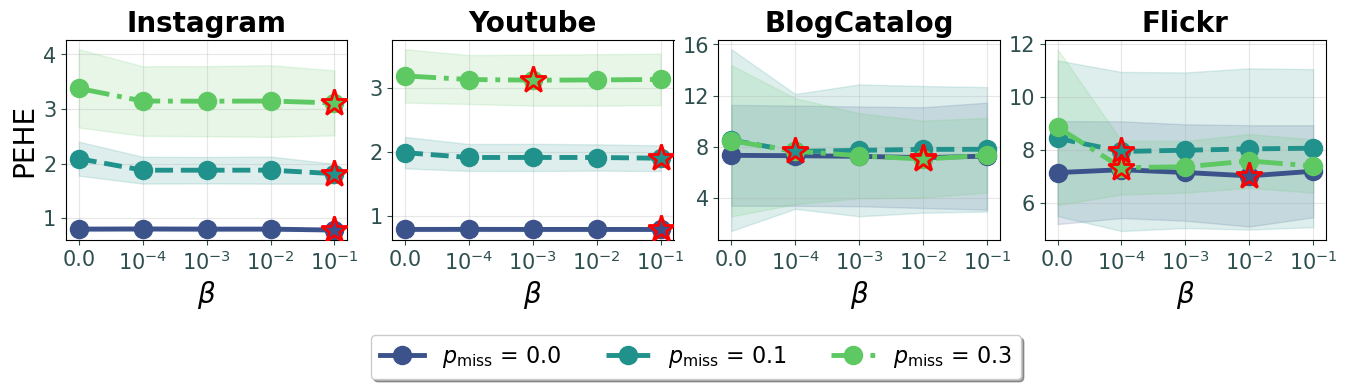

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from line_plots import plot_results
dataset_map = {'Syn_M=None_SimRel=1_Rel=4':"Instagram",  'BlogCatalog1_M=20_SimRel=0_Rel=1':"BlogCatalog", 'BlogCatalog1_M=20_SimRel=1_Rel=4':"BlogCatalog", 'Flickr1_M=20_SimRel=0_Rel=1':"Flickr", 'Flickr1_M=20_SimRel=1_Rel=4':"Flickr", 'Youtube_M=20_SimRel=1_Rel=4':"Youtube"}
    

def process_df(df, method, hyper, metric='SUM'):
    def map_fun(x):
        x = str(x)
        for k, v in dataset_map.items():
            if k in x:
                return v
        return x
    def get_hyper(x):
        x = str(x)
        j = x.index('=')+1
        return x[j:]
    df = df[['method', "Dataset"]+[col for col in df.columns if metric in col]]
    new_column_names = [replace_col(col) for col in df.columns]
    df.columns = new_column_names
    # rows
    df = df[df['method'].str.contains(method, na=False)]
    # process
    df[f"$\\{hyper}$"] = df['method'].apply(lambda x: get_hyper(x))
    
    df['Dataset'] = df['Dataset'].apply(lambda x: map_fun(x))
    df.drop(columns=['method'], inplace=True)
    return df

def replace_col(col):
    for k, v in dataset_map.items():
        if k in col:
            return col.replace(k, v).replace("_MCAR","")
    return col


method='BaLu_GRAPE'
hyper='beta'
metric='PEHE'
train_test_flag= "test"

result_df = None
for p in ['0.0', '0.1', '0.3']:
    _, df = collect_data_p(p, datasets=datasets, result_dir=result_dir, train_test_flag=train_test_flag)
    df = process_df(df, method=method, hyper=hyper, metric=metric)
    df['$p_{\\text{miss}}$'] = [p]*len(df)
    
    if result_df is None:
        result_df = df 
    else:
        result_df = pd.concat([result_df, df], ignore_index=True)

fig, axes = plot_results(result_df, metric=metric, hyper=f"$\\{hyper}$", save_pdf='figs/beta.pdf')
